# ⚡ Train and visualize a Lightning Pose model ⚡

Using a toy dataset (a.k.a. "mirror-mouse") with 90 labeled images from Warren et al., 2022 (eLife).
* [Environment setup](#Environment-setup)
* [Train (via PyTorch Lightning)](#Training)
* [Monitor optimization in real time (via TensorBoard UI)](#Monitor-training)
* [Compute diagnostics on labeled and video data](#Compute-diagnostics)
* [Compare train / val / test images (via FiftyOne UI)](#FiftyOne)
* [Video predictions and diagnostics](#Plot-video-predictions-and-unsupervised-losses)


**Make sure to use a GPU runtime!**

To do so, in the upper right corner of this notebook:
* click the "Connect" button (or select "Connect to a hosted runtime" from the drop-down)
* ensure you are connected to a GPU by clicking the down arrow, selecting "View resources" from the menu, and make sure you see "Python 3 Google Compute Engine backend (GPU)"

## Environment setup

In [1]:
! pwd
# ! cp -r /lightning-pose/ ../scratch/lightning-pose/

! ls -lt /root/capsule/scratch/lightning-pose/

/root/capsule/code
total 72
drwxr-xr-x 3 root root 6144 Jul 30 03:46 scripts
-rw-r--r-- 1 root root 2405 Jul 30 03:11 setup.py
-rw-r--r-- 1 root root 7012 Jul 30 03:11 README.md
-rw-r--r-- 1 root root  358 Jul 30 03:11 MANIFEST.in
-rw-r--r-- 1 root root 1069 Jul 30 03:11 LICENSE
-rw-r--r-- 1 root root  564 Jul 30 03:11 Dockerfile.cuda12
-rw-r--r-- 1 root root  751 Jul 30 03:11 Dockerfile.cuda11
drwxr-xr-x 3 root root 6144 Jun 16 19:07 outputs_Han_dataset
drwxr-xr-x 3 root root 6144 Jun 16 18:48 outputs_Han_dataset_epoch100
drwxr-xr-x 4 root root 6144 Jun 15 00:51 toy_datasets
drwxr-xr-x 2 root root 6144 Jun 14 23:36 Han_datasets
drwxr-xr-x 3 root root 6144 Jun 14 21:03 tb_logs
drwxr-xr-x 2 root root 6144 Jun 14 21:03 lightning_pose.egg-info
drwxr-xr-x 6 root root 6144 Jun 14 21:03 tests
drwxr-xr-x 3 root root 6144 Jun 14 21:03 assets
drwxr-xr-x 8 root root 6144 Jun 14 21:03 lightning_pose
drwxr-xr-x 2 root root 6144 Jun 14 21:03 docs


In [22]:
working_dir = "/root/capsule/scratch/lightning-pose/"
! ls -lt $working_dir

total 72
drwxr-xr-x 3 root root 6144 Jul 30 03:46 scripts
-rw-r--r-- 1 root root 2405 Jul 30 03:11 setup.py
-rw-r--r-- 1 root root 7012 Jul 30 03:11 README.md
-rw-r--r-- 1 root root  358 Jul 30 03:11 MANIFEST.in
-rw-r--r-- 1 root root 1069 Jul 30 03:11 LICENSE
-rw-r--r-- 1 root root  564 Jul 30 03:11 Dockerfile.cuda12
-rw-r--r-- 1 root root  751 Jul 30 03:11 Dockerfile.cuda11
drwxr-xr-x 3 root root 6144 Jun 16 19:07 outputs_Han_dataset
drwxr-xr-x 3 root root 6144 Jun 16 18:48 outputs_Han_dataset_epoch100
drwxr-xr-x 4 root root 6144 Jun 15 00:51 toy_datasets
drwxr-xr-x 2 root root 6144 Jun 14 23:36 Han_datasets
drwxr-xr-x 3 root root 6144 Jun 14 21:03 tb_logs
drwxr-xr-x 2 root root 6144 Jun 14 21:03 lightning_pose.egg-info
drwxr-xr-x 6 root root 6144 Jun 14 21:03 tests
drwxr-xr-x 3 root root 6144 Jun 14 21:03 assets
drwxr-xr-x 8 root root 6144 Jun 14 21:03 lightning_pose
drwxr-xr-x 2 root root 6144 Jun 14 21:03 docs


In [3]:
# optional: run our unit tests (takes 4-5 minutes on a T4)

# NOTE: you may see the following error:
#    RuntimeError: timed out waiting for adapter to connect
# As long as you see this on the following line:
#    ============================= test session starts ==============================
# then the notebook is working properly

# !pytest

## Training

In [4]:
import hydra
from omegaconf import DictConfig, OmegaConf
import os
import lightning.pytorch as pl

from lightning_pose.utils import pretty_print_str, pretty_print_cfg
from lightning_pose.utils.io import (
    check_video_paths,
    return_absolute_data_paths,
    return_absolute_path,
)
from lightning_pose.utils.predictions import predict_dataset
from lightning_pose.utils.scripts import (
    export_predictions_and_labeled_video,
    get_data_module,
    get_dataset,
    get_imgaug_transform,
    get_loss_factories,
    get_model,
    get_callbacks,
    calculate_train_batches,
    compute_metrics,
)

In [5]:
! ls 

 analysis_prediction	       main.py
 analysis.py		       organize_data_funcs.py
 behavior_data		       organize_data.py
 config_test.yaml	       __pycache__
 funcs.py		       run
 generate_dataset.py	      'run copy'
 litpose_training_demo.ipynb   run_copy_2
 litpose_training_demo.py      sleap_video_shuffle1.predictions.analysis.csv
 main_leave_mouse_out.py       tb_logs


In [6]:
! pwd

/root/capsule/code


In [7]:
working_dir

'/root/capsule/scratch/lightning-pose/'

In [8]:
# read hydra configuration file from lightning-pose/scripts/configs/config_toy-dataset.yaml
cfg = OmegaConf.load(working_dir + "scripts/configs/config_toy-dataset.yaml")

# get absolute data and video directories for toy dataset
data_dir = os.path.join(working_dir, cfg.data.data_dir)
video_dir = os.path.join(working_dir, cfg.data.data_dir, cfg.data.video_dir)
cfg.data.data_dir = data_dir
cfg.data.video_dir = video_dir

assert os.path.isdir(cfg.data.data_dir), "data_dir not a valid directory"
assert os.path.isdir(cfg.data.video_dir), "video_dir not a valid directory"


In [9]:
cfg.data.data_dir
# data_dir

'/root/capsule/scratch/lightning-pose/toy_datasets/toymouseRunningData'

In [10]:
# build dataset, model, and trainer

# make training short for a demo (we usually do 300)
# cfg.training.min_epochs = 100
# cfg.training.max_epochs = 150
cfg.training.min_epochs = 10
cfg.training.max_epochs = 15
cfg.training.batch_size = 8

# build imgaug transform
imgaug_transform = get_imgaug_transform(cfg=cfg)

# build dataset
dataset = get_dataset(cfg=cfg, data_dir=data_dir, imgaug_transform=imgaug_transform)

# build datamodule; breaks up dataset into train/val/test
data_module = get_data_module(cfg=cfg, dataset=dataset, video_dir=video_dir)

# build loss factory which orchestrates different losses
loss_factories = get_loss_factories(cfg=cfg, data_module=data_module)

# build model
model = get_model(cfg=cfg, data_module=data_module, loss_factories=loss_factories)

# logger
logger = pl.loggers.TensorBoardLogger("tb_logs", name=cfg.model.model_name)

# early stopping, learning rate monitoring, model checkpointing, backbone unfreezing
callbacks = get_callbacks(cfg)

# calculate number of batches for both labeled and unlabeled data per epoch
limit_train_batches = calculate_train_batches(cfg, dataset)

# set up trainer
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=cfg.training.max_epochs,
    min_epochs=cfg.training.min_epochs,
    check_val_every_n_epoch=cfg.training.check_val_every_n_epoch,
    log_every_n_steps=cfg.training.log_every_n_steps,
    callbacks=callbacks,
    logger=logger,
    limit_train_batches=limit_train_batches,
)


using dlc image augmentation pipeline
Number of labeled images in the full dataset (train+val+test): 90
Size of -- train set: 72, val set: 9, test set: 9
Number of labeled images in the full dataset (train+val+test): 90
Size of -- train set: 72, val set: 9, test set: 9
Results of running PCA (pca_singleview) on keypoints:
Kept 13/28 components, and found:
Explained variance ratio: [0.315 0.242 0.209 0.073 0.048 0.034 0.021 0.015 0.01  0.007 0.007 0.005
 0.004 0.003 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 13 components: 0.991

 Initializing a SemiSupervisedHeatmapTracker instance.


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 332MB/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [48]:
cfg

{'data': {'image_orig_dims': {'width': 396, 'height': 406}, 'image_resize_dims': {'width': 256, 'height': 256}, 'data_dir': '/root/capsule/scratch/lightning-pose/toy_datasets/toymouseRunningData', 'video_dir': '/root/capsule/scratch/lightning-pose/toy_datasets/toymouseRunningData/unlabeled_videos', 'csv_file': 'CollectedData_.csv', 'header_rows': [1, 2], 'downsample_factor': 2, 'num_keypoints': 17, 'mirrored_column_matches': [[0, 1, 2, 3, 4, 5, 6], [8, 9, 10, 11, 12, 13, 14]], 'columns_for_singleview_pca': [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14]}, 'training': {'imgaug': 'default', 'train_batch_size': 16, 'val_batch_size': 16, 'test_batch_size': 16, 'train_prob': 0.8, 'val_prob': 0.1, 'train_frames': 1, 'num_gpus': 0, 'num_workers': 4, 'early_stop_patience': 3, 'unfreezing_epoch': 20, 'dropout_rate': 0.1, 'min_epochs': 10, 'max_epochs': 15, 'log_every_n_steps': 1, 'check_val_every_n_epoch': 10, 'gpu_id': 0, 'rng_seed_data_pt': 42, 'rng_seed_model_pt': 44, 'lr_scheduler': 'multis

In [46]:
## examine the confidence level

import torch
import matplotlib.pyplot as plt
import numpy as np

def display_single_image(in_data):
    num_per_fig_x = 1
    num_per_fig_y = 1

    vmin = None
    vmax = None

    fig, axes = plt.subplots(nrows=num_per_fig_x, ncols=num_per_fig_y, figsize=(5, 5))
    img = axes.imshow((np.rot90(in_data)), cmap='jet', vmin=vmin, vmax=vmax)
    axes.label_outer()
    axes.set_axis_off()
    plt.show()
#     plt.savefig(savefig_path+'.png', bbox_inches = 'tight', pad_inches = 0.01)
#     plt.close()


#################################

train_dataset = data_module.train_dataset  # just access training data
i = 10
image = train_dataset[i]

# train_dataset.image_names will return a list; say you want to look at the ith image from that list

with torch.inference_mode():
    # push image through model
    pred_heatmaps = model.forward(image['images'].unsqueeze(0))
    # send to numpy
    pred_heatmaps = pred_heatmaps.detach().cpu().numpy()
    
print(image['images'].shape)
print(pred_heatmaps.shape)

display_single_image(np.squeeze(image['images'][0, :, :]))  
display_single_image(np.squeeze(pred_heatmaps[:, 10, :]))

torch.Size([3, 256, 256])

torch.Size([3, 256, 256])
(1, 17, 64, 64)


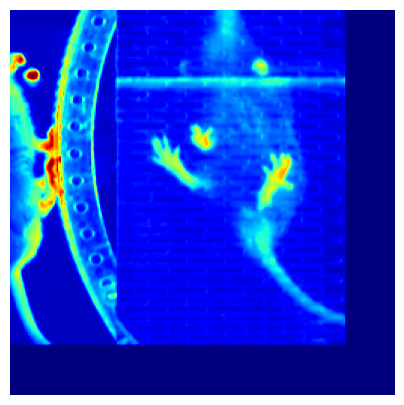

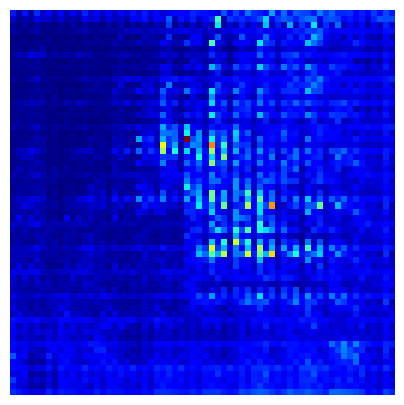

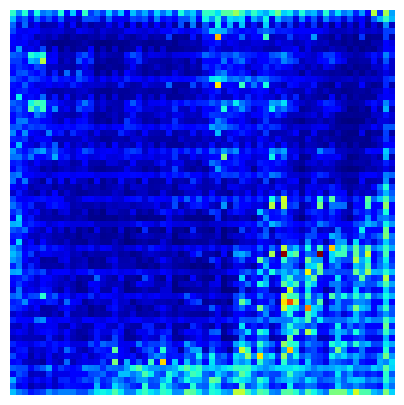

## Monitor training

In [18]:
%matplotlib inline

In [19]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [20]:
# Launch tensorboard before launching training (happens in next cell).
# If you receive a 403 error, be sure to enable all cookies for this site in your browser.
# To see the losses during training, select TIME SERIES and hit the refresh button (circle arrow) on the top right.

# The two most important diagnostics are:
# - `train_supervised_rmse`: root mean square error (rmse) of predictions on training data
# - `val_supervised_rmse`: rmse on validation data

%tensorboard --logdir tb_logs

In [21]:
# Train the model (approx 15-20 mins on this T4 GPU machine)
trainer.fit(model=model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type               | Params
----------------------------------------------------------
0 | backbone           | Sequential         | 23.5 M
1 | loss_factory       | LossFactory        | 0     
2 | upsampling_layers  | Sequential         | 81.0 K
3 | rmse_loss          | RegressionRMSELoss | 0     
4 | loss_factory_unsup | LossFactory        | 0     
----------------------------------------------------------
134 K     Trainable params
23.5 M    Non-trainable params
23.6 M    Total params
94.356    Total estimated model params size (MB)


Number of labeled images in the full dataset (train+val+test): 90
Size of -- train set: 72, val set: 9, test set: 9


`Trainer.fit` stopped: `max_epochs=15` reached.


## Compute diagnostics
* Get model predictions for train, validation, and test sets; use these to compute per-keypoint pixel errors and unsupervised losses
* Get model predictions on a test video, and compute unsupervised losses

### Predictions/diagnostics for labeled data

In [23]:
from datetime import datetime

# Get the current date and time
now = datetime.now()

# Format the date and time as a string in the desired format
formatted_now = now.strftime("%Y-%m-%d/%H-%M-%S")

output_directory = os.path.join(working_dir + "/outputs", formatted_now)
os.makedirs(output_directory)
print(f"Created an output directory at: {output_directory}")

# get best ckpt
best_ckpt = os.path.abspath(trainer.checkpoint_callback.best_model_path)

# check if best_ckpt is a file
if not os.path.isfile(best_ckpt):
    raise FileNotFoundError("Cannot find checkpoint. Have you trained for too few epochs?")

# make unaugmented data_loader if necessary
if cfg.training.imgaug != "default":
    cfg_pred = cfg.copy()
    cfg_pred.training.imgaug = "default"
    imgaug_transform_pred = get_imgaug_transform(cfg=cfg_pred)
    dataset_pred = get_dataset(
        cfg=cfg_pred, data_dir=data_dir, imgaug_transform=imgaug_transform_pred
    )
    data_module_pred = get_data_module(cfg=cfg_pred, dataset=dataset_pred, video_dir=video_dir)
    data_module_pred.setup()
else:
    data_module_pred = data_module

# compute and save frame-wise predictions
pretty_print_str("Predicting train/val/test images...")
preds_file = os.path.join(output_directory, "predictions.csv")
predict_dataset(
    cfg=cfg,
    trainer=trainer,
    model=model,
    data_module=data_module_pred,
    ckpt_file=best_ckpt,
    preds_file=preds_file,
)

# compute and save various metrics
try:
    compute_metrics(cfg=cfg, preds_file=preds_file, data_module=data_module_pred)
except Exception as e:
    print(f"Error computing metrics\n{e}")

Created an output directory at: /root/capsule/scratch/lightning-pose//outputs/2023-07-30/04-39-56
using default image augmentation pipeline (resizing only)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of labeled images in the full dataset (train+val+test): 90
Size of -- train set: 72, val set: 9, test set: 9
Number of labeled images in the full dataset (train+val+test): 90
Size of -- train set: 72, val set: 9, test set: 9
-----------------------------------
Predicting train/val/test images...
-----------------------------------
Number of labeled images in the full dataset (train+val+test): 90
Size of -- train set: 72, val set: 9, test set: 9



Results of running PCA (pca_singleview) on keypoints:
Kept 13/28 components, and found:
Explained variance ratio: [0.315 0.242 0.209 0.073 0.048 0.034 0.021 0.015 0.01  0.007 0.007 0.005
 0.004 0.003 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 13 components: 0.991
Results of running PCA (pca_multiview) on keypoints:
Kept 3/4 components, and found:
Explained variance ratio: [0.903 0.06  0.036 0.001]
Variance explained by 3 components: 0.999


In [24]:
! ls -lt $output_directory

total 180
-rw-r--r-- 1 root root 26904 Jul 30 04:39 predictions_pca_multiview_error.csv
-rw-r--r-- 1 root root 26804 Jul 30 04:39 predictions_pca_singleview_error.csv
-rw-r--r-- 1 root root 29322 Jul 30 04:39 predictions_pixel_error.csv
-rw-r--r-- 1 root root 94016 Jul 30 04:39 predictions.csv


In [25]:
artifacts = os.listdir(output_directory)
print("Generated the following diagnostic csv files:")
print(artifacts)

Generated the following diagnostic csv files:
['predictions_pixel_error.csv', 'predictions_pca_singleview_error.csv', 'predictions.csv', 'predictions_pca_multiview_error.csv']


### Predictions/diagnostics for example video

In [26]:
# for this demo data, we define
cfg.eval.test_videos_directory = video_dir
# feel free to change this according to the folder you want to predict
assert os.path.isdir(cfg.eval.test_videos_directory)

if cfg.eval.test_videos_directory is None:
    filenames = []
else:
    filenames = check_video_paths(return_absolute_path(cfg.eval.test_videos_directory))
    vidstr = "video" if (len(filenames) == 1) else "videos"
    pretty_print_str(
        f"Found {len(filenames)} {vidstr} to predict on (in cfg.eval.test_videos_directory)")

for video_file in filenames:
    assert os.path.isfile(video_file)
    pretty_print_str(f"Predicting video: {video_file}...")
    # get save name for prediction csv file
    video_pred_dir = os.path.join(output_directory, "video_preds")
    video_pred_name = os.path.splitext(os.path.basename(video_file))[0]
    prediction_csv_file = os.path.join(video_pred_dir, video_pred_name + ".csv")
    # get save name labeled video csv
    if cfg.eval.save_vids_after_training:
        labeled_vid_dir = os.path.join(video_pred_dir, "labeled_videos")
        labeled_mp4_file = os.path.join(labeled_vid_dir, video_pred_name + "_labeled.mp4")
    else:
        labeled_mp4_file = None
    # predict on video
    export_predictions_and_labeled_video(
        video_file=video_file,
        cfg=cfg,
        ckpt_file=best_ckpt,
        prediction_csv_file=prediction_csv_file,
        labeled_mp4_file=labeled_mp4_file,
        trainer=trainer,
        model=model,
        data_module=data_module_pred,
        save_heatmaps=cfg.eval.get("predict_vids_after_training_save_heatmaps", False),
    )
    # compute and save various metrics
    try:
        compute_metrics(
            cfg=cfg, preds_file=prediction_csv_file, data_module=data_module_pred
        )
    except Exception as e:
        print(f"Error predicting on video {video_file}:\n{e}")
        continue

Restoring states from the checkpoint path at /root/capsule/code/tb_logs/my_base_toy_model/version_5/checkpoints/epoch=9-step=100.ckpt


---------------------------------------------------------------
Found 1 video to predict on (in cfg.eval.test_videos_directory)
---------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Predicting video: /root/capsule/scratch/lightning-pose/toy_datasets/toymouseRunningData/unlabeled_videos/test_vid.mp4...
------------------------------------------------------------------------------------------------------------------------
Number of labeled images in the full dataset (train+val+test): 90
Size of -- train set: 72, val set: 9, test set: 9


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /root/capsule/code/tb_logs/my_base_toy_model/version_5/checkpoints/epoch=9-step=100.ckpt


t:   5%|▍         | 48/995 [00:00<00:02, 424.14it/s, now=None]

Duration of video [s]: 3, recorded with 250.0 fps!
Moviepy - Building video /root/capsule/scratch/lightning-pose//outputs/2023-07-30/04-39-56/video_preds/labeled_videos/test_vid_labeled.mp4.
Moviepy - Writing video /root/capsule/scratch/lightning-pose//outputs/2023-07-30/04-39-56/video_preds/labeled_videos/test_vid_labeled.mp4



Skipped frame 994, marker 0
Skipped frame 994, marker 1
Skipped frame 994, marker 2
Skipped frame 994, marker 3
Skipped frame 994, marker 4
Skipped frame 994, marker 5
Skipped frame 994, marker 6
Skipped frame 994, marker 7
Skipped frame 994, marker 8
Skipped frame 994, marker 9
Skipped frame 994, marker 10
Skipped frame 994, marker 11
Skipped frame 994, marker 12
Skipped frame 994, marker 13
Skipped frame 994, marker 14
Skipped frame 994, marker 15
Skipped frame 994, marker 16
Moviepy - Done !
Moviepy - video ready /root/capsule/scratch/lightning-pose//outputs/2023-07-30/04-39-56/video_preds/labeled_videos/test_vid_labeled.mp4
Results of running PCA (pca_singleview) on keypoints:
Kept 13/28 components, and found:
Explained variance ratio: [0.315 0.242 0.209 0.073 0.048 0.034 0.021 0.015 0.01  0.007 0.007 0.005
 0.004 0.003 0.002 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 13 components: 0.991
Results of running PCA (pca_multiview)

### Display the short labeled video
Includes network predictions.
Make sure your video is not too large for this; it may cause memory issues.


In [27]:
from IPython.display import HTML
from base64 import b64encode

vids = os.listdir(labeled_vid_dir)
mp4 = open(os.path.join(labeled_vid_dir, vids[0]),'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


In [27]:
# # download vids to your local machine if desired
# from google.colab import files
# for vid in vids:
#     if vid.endswith(".mp4"):
#         files.download(os.path.join(labeled_vid_dir, vid))

## FiftyOne
We use `fiftyone` to visualize our models' predictions on labeled images. We will create a dataset with predictions, and then display it in a UI below.

In [28]:
# Override the default configs here:
cfg.eval.hydra_paths=[output_directory] # you can add multiple output_directory2, output_directory3 to compare
cfg.eval.fiftyone.dataset_to_create="images"
cfg.eval.fiftyone.dataset_name="lightning-demo-colab"
cfg.eval.fiftyone.build_speed="fast"
cfg.eval.fiftyone.model_display_names=["semi"]

In [29]:
cfg.eval.fiftyone

{'dataset_name': 'lightning-demo-colab', 'build_speed': 'fast', 'model_display_names': ['semi'], 'launch_app_from_script': False, 'remote': True, 'address': '127.0.0.1', 'port': 5151, 'dataset_to_create': 'images'}

In [30]:
! cp -r ../scratch/lightning-pose/toy_datasets/toymouseRunningData/unlabeled_videos ../scratch/lightning-pose/toy_datasets/toymouseRunningData/unlabeled_video

In [31]:
! ls -lt ../scratch/lightning-pose/toy_datasets/toymouseRunningData/unlabeled_video

total 1692
drwxr-xr-x 2 root root    6144 Jun 14 21:50 unlabeled_videos
-rw-r--r-- 1 root root 1724850 Jun 14 21:41 test_vid.mp4


In [32]:
! $video_dir
! ls -lt $video_dir

/bin/bash: /root/capsule/scratch/lightning-pose/toy_datasets/toymouseRunningData/unlabeled_videos: Is a directory
total 1688
-rw-r--r-- 1 root root 1724850 Jun 14 21:03 test_vid.mp4


In [33]:
import fiftyone as fo
from lightning_pose.utils.fiftyone import (
    FiftyOneImagePlotter,
    FiftyOneKeypointVideoPlotter,
    check_dataset,
    FiftyOneFactory,
)

# initializes everything
FiftyOneClass = FiftyOneFactory(
        dataset_to_create=cfg.eval.fiftyone.dataset_to_create
    )()


Migrating database to v0.20.1


In [34]:
FiftyOneClass

lightning_pose.utils.fiftyone.FiftyOneImagePlotter

In [35]:
cfg.data.data_dir

'/root/capsule/scratch/lightning-pose/toy_datasets/toymouseRunningData'

In [36]:
fo_plotting_instance = FiftyOneClass(cfg=cfg)

Plotting:  ['nose_bot', 'nose_top', 'obsHigh_bot', 'obsLow_bot', 'obs_top', 'paw1LH_bot', 'paw1LH_top', 'paw2LF_bot', 'paw2LF_top', 'paw3RF_bot', 'paw3RF_top', 'paw4RH_bot', 'paw4RH_top', 'tailBase_bot', 'tailBase_top', 'tailMid_bot', 'tailMid_top']


In [37]:

# internally loops over models
dataset = fo_plotting_instance.create_dataset()

# create metadata and print if there are problems
check_dataset(dataset)
fo_plotting_instance.dataset_info_print()


 49%|████▉     | 44/90 [00:00<00:00, 439.05it/s]

 50%|█████     | 45/90 [00:00<00:00, 445.25it/s]

100%|██████████| 90/90 [00:00<00:00, 18581.71it/s]


--------------------------------------------------------------------------
Appending fiftyone.Keypoints to fiftyone.Sample objects, for each image...
--------------------------------------------------------------------------
--------------------------------
Adding samples to the dataset...
--------------------------------
 100% |███████████████████| 90/90 [310.2ms elapsed, 0s remaining, 290.2 samples/s]     
-----
Done!
-----
---------------------------------------------------
Checking FiftyOne.Dataset by computing metadata... 
---------------------------------------------------
Computing metadata...
 100% |███████████████████| 90/90 [1.4s elapsed, 0s remaining, 63.0 samples/s]   
----------------------------------------------------------------------------------------------------------------------
Created FiftyOne dataset called: lightning-demo-colab. To access it in python: fo.load_dataset("lightning-demo-colab")
------------------------------------------------------------------------

In [56]:
fo.load_dataset("lightning-demo-colab")

Name:        lightning-demo-colab
Media type:  image
Num samples: 90
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Keypoints)
    semi_preds:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Keypoints)

In [57]:
# Launch the FiftyOne UI
# - Select the dataset you just built (e.g., `lightning-pose-demo`) on the top left dropdown menu.
# - If you receive a 403 error, be sure to enable all cookies for this site in your browser
fo.launch_app()

Dataset:     -
Session URL: http://0.0.0.0:5151/

## Plot video predictions and unsupervised losses

### Load data

In [53]:
from collections import defaultdict
import pandas as pd
from pathlib import Path

from lightning_pose.apps.utils import build_precomputed_metrics_df, get_col_names, concat_dfs
from lightning_pose.apps.utils import update_vid_metric_files_list
from lightning_pose.apps.utils import get_model_folders, get_model_folders_vis
from lightning_pose.apps.plots import plot_precomputed_traces

# select which model(s) to use
model_folders = get_model_folders(working_dir + "/outputs")

# get the last two levels of each path to be presented to user
model_names = get_model_folders_vis(model_folders)

# get prediction files for each model
prediction_files = update_vid_metric_files_list(video="test_vid", model_preds_folders=model_folders)

# load data
dframes_metrics = defaultdict(dict)
dframes_traces = {}
for p, model_pred_files in enumerate(prediction_files):
    model_name = model_names[p]
    model_folder = model_folders[p]
    for model_pred_file in model_pred_files:
        model_pred_file_path = os.path.join(model_folder, "video_preds", model_pred_file)
        if not isinstance(model_pred_file, Path):
            model_pred_file.seek(0)  # reset buffer after reading
        if "pca" in str(model_pred_file) or "temporal" in str(model_pred_file) or "pixel" in str(model_pred_file):
            dframe = pd.read_csv(model_pred_file_path, index_col=None)
            dframes_metrics[model_name][str(model_pred_file)] = dframe
        else:
            dframe = pd.read_csv(model_pred_file_path, header=[1, 2], index_col=0)
            dframes_traces[model_name] = dframe
            dframes_metrics[model_name]["confidence"] = dframe
        data_types = dframe.iloc[:, -1].unique()

# compute metrics
# concat dataframes, collapsing hierarchy and making df fatter.
df_concat, keypoint_names = concat_dfs(dframes_traces)
df_metrics = build_precomputed_metrics_df(
    dframes=dframes_metrics, keypoint_names=keypoint_names)
metric_options = list(df_metrics.keys())

# print keypoint names; select one of these to plot below
print(keypoint_names)

# NOTE: you can ignore all errors and warnings of the type:
#    No runtime found, using MemoryCacheStorageManager

2023-06-14 22:20:10.612 No runtime found, using MemoryCacheStorageManager
2023-06-14 22:20:10.643 No runtime found, using MemoryCacheStorageManager
2023-06-14 22:20:10.690 No runtime found, using MemoryCacheStorageManager
2023-06-14 22:20:10.695 No runtime found, using MemoryCacheStorageManager


['paw1LH_top', 'paw2LF_top', 'paw3RF_top', 'paw4RH_top', 'tailBase_top', 'tailMid_top', 'nose_top', 'obs_top', 'paw1LH_bot', 'paw2LF_bot', 'paw3RF_bot', 'paw4RH_bot', 'tailBase_bot', 'tailMid_bot', 'nose_bot', 'obsHigh_bot', 'obsLow_bot']


### Plot video traces

In [55]:
# rerun this cell each time you want to update the keypoint

from IPython.display import display, clear_output
import ipywidgets as widgets

def on_change(change):
    if change["type"] == "change" and change["name"] == "value":
        clear_output()
        cols = get_col_names(change["new"], "x", dframes_metrics.keys())
        fig_traces = plot_precomputed_traces(df_metrics, df_concat, cols)
        fig_traces.show()

# create a Dropdown widget
dropdown = widgets.Dropdown(
    options=keypoint_names,
    value=None,  # Set the default selected value
    description="Select keypoint:",
)

# update plot upon change
dropdown.observe(on_change)

# display widget
display(dropdown)